### **Installation**

In [1]:
pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 59.3 MB/s eta 0:00:00
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2


In [2]:
# pip install amazon-braket-pennylane-plugin

In [3]:
# pip install pennylane-qiskit

### **Libs**

In [4]:
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import NesterovMomentumOptimizer
import numpy as np
from numpy.random import sample
import matplotlib.pyplot as plt
# import qiskit

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# import torch
# from torch import nn
# import torchvision
# from torchvision import transforms
# from torch.utils.data import TensorDataset, DataLoader

import matplotlib as mpl
import sklearn
from sklearn import datasets
import seaborn as sns
import pandas as pd
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# import boto3

# session = boto3.Session(region_name='us-west-1')
# s3_client = session.client('s3')

### **Quantum Circuit**

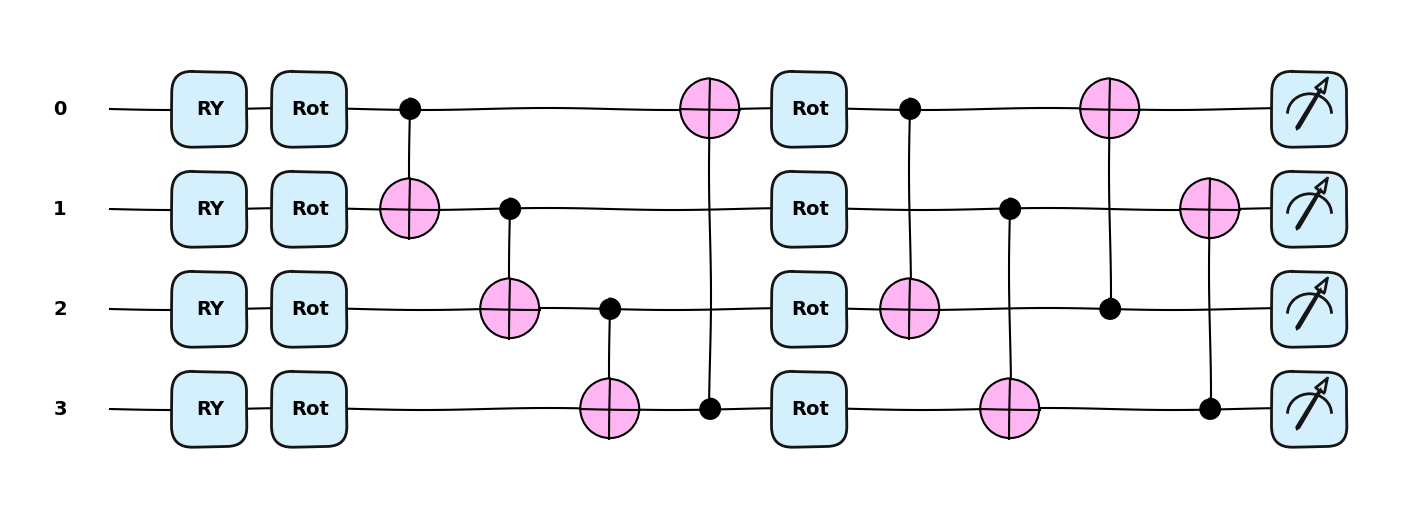

In [127]:
num_wires = 4
n_layer = 2
dev = qml.device("lightning.qubit", wires=num_wires)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layer, num_wires,3))
weights = np.random.rand(15, 1)
@qml.qnode(dev, interface="autograd")
def qconv(weights,phi):
    # Encoding of 4 classical input values
    for j in range(num_wires):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    # qml.RandomLayers(rand_params,ratio_imprim=0.3, wires=list(range(num_wires)))
    qml.StronglyEntanglingLayers(rand_params, wires=list(range(num_wires)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(num_wires)]
ip =  [weights,np.random.rand(num_wires)]
fig, ax = qml.draw_mpl(qconv,style='pennylane',expansion_strategy='device')(*ip)
plt.show()

### **Digits Dataset**

In [105]:
def load_digits_data_2():
    """Return training and testing data of digits dataset."""
    digits = datasets.load_digits()
    # dat = sample(digits,n)
    features, labels = digits.data, digits.target

    # only use first two classes
    features = features
    labels = labels
    features = features / np.linalg.norm(features, axis=1).reshape((-1, 1))
    x_train,x,y_train,y = train_test_split(features,labels,test_size=0.3,random_state=2)
    x_val,x_test,y_val,y_test = train_test_split(x,y,test_size=0.5,random_state=2)
    # scaler = MinMaxScaler(feature_range = (0, 1))
    # x_train = scaler.fit_transform(x_train)
    # x_val = scaler.fit_transform(x_val)
    # Add extra dimension for convolution channels
    # scaler = MinMaxScaler(feature_range = (0, 1))
    # x_train = scaler.fit_transform(x_train)
    # x_val = scaler.fit_transform(x_val)
    # x_test = scaler.fit_transform(x_test)

    x_train = x_train.reshape(len(x_train), 8, 8,1)
    # Reshape the label
    y_train = y_train.reshape(len(y_train))
    # y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
    x_val = x_val.reshape(len(x_val), 8, 8,1)
    y_val = y_val.reshape(len(y_val))
    x_test = x_test.reshape(len(x_test), 8, 8,1)
    y_test = y_test.reshape(len(y_test))
    # x_train = pnp.array(x_train[..., tf.newaxis], requires_grad=False)
    # x_val = pnp.array(x_val[..., tf.newaxis], requires_grad=False)
    # x_test = pnp.array(x_test[..., tf.newaxis], requires_grad=False)
    return (x_train,x_val,y_train,y_val,x_test,y_test)

In [ ]:
x_train,x_val,y_train,y_val,x_test,y_test = load_digits_data_2()

### **Quantum Preprocess**

In [12]:
def quanv(weights,image,out_channels=num_wires,kernel_size=2,stride=2):
    """Convolves the input image with many applications of the same quantum circuit."""
    h,w,ch = image.shape

    h_out = (h-kernel_size)//stride+1
    w_out = (w-kernel_size)//stride+1
    out = np.zeros((h_out, w_out, out_channels))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, h, stride):
        for k in range(0, w, stride):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = qconv(weights,
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    # image[j, k + 2, 0],
                    # image[j, k + 3, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0],
                    # image[j + 1, k + 2, 0],
                    # image[j + 1, k + 3, 0],
                    # image[j + 2, k, 0],
                    # image[j + 2, k+1, 0],
                    # image[j + 2, k+2, 0],
                    # image[j + 2, k+3, 0],
                    # image[j + 3, k, 0],
                    # image[j + 3, k + 1, 0],
                    # image[j + 3, k + 2, 0],
                    # image[j + 3, k + 3, 0],

                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(out_channels):
                out[j // kernel_size, k // kernel_size, c] = q_results[c]
    return out

In [14]:
q_train_images = []

print("Quantum pre-processing of train images:")
for idx, img in enumerate(x_train):
   print("{}/{}        ".format(idx + 1,len(x_train)), end="\r")
   q_train_images.append(quanv(weights,img))
q_train_images = np.asarray(q_train_images)

Quantum pre-processing of train images:


In [15]:
np.array(q_train_images).shape

(1257, 4, 4, 4)

In [16]:
q_val_images = []
print("\nQuantum pre-processing of test images:")
for idx, img in enumerate(x_val):
   print("{}/{}        ".format(idx + 1,len(x_val)), end="\r")
   q_val_images.append(quanv(weights,img))
q_val_images = np.asarray(q_val_images)


Quantum pre-processing of test images:


In [17]:
np.asarray(q_val_images).shape

(270, 4, 4, 4)

In [18]:
q_test_images = []
print("\nQuantum pre-processing of test images:")
for idx, img in enumerate(x_test):
   print("{}/{}        ".format(idx + 1, len(x_test)), end="\r")
   q_test_images.append(quanv(weights,img))
q_test_images = np.asarray(q_test_images)


Quantum pre-processing of test images:


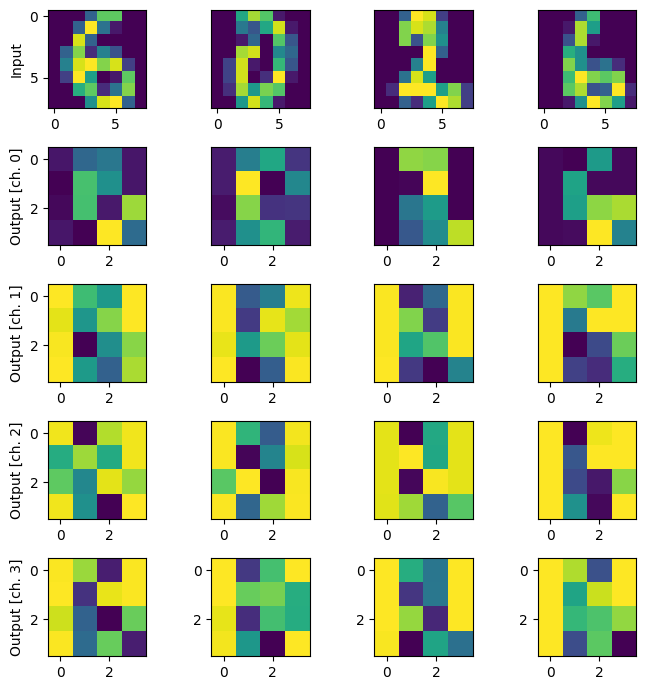

In [19]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(7, 7))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(x_train[k, :, :, 0])

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c])

plt.tight_layout()
plt.show()

### **QNN vs CNN model**

In [89]:
def model():
  flat = layers.Flatten()
  pool = layers.MaxPool2D((1,1))
  clayer1 = layers.Dense(64,activation='elu',name='d1')
  bn = layers.BatchNormalization()
  conv = layers.Conv2D(4,kernel_size=1,input_shape=[4,4,4])
  clayer2 = layers.Dense(32,activation='elu',name='d2')
  clayer3 = layers.Dense(16,activation='elu',name='d3')
  drop1 = layers.Dropout(0.2)
  drop2 = layers.Dropout(0.2)
  clayer4 = layers.Dense(10, activation="softmax",name='d4')
  # model = keras.Sequential([flat, clayer1,bn, drop, clayer2 ,drop, clayer3,bn,drop, clayer4])
  model = keras.Sequential([conv,flat,clayer2,drop1,clayer3,clayer4])

  opt = tf.keras.optimizers.Adam(learning_rate=0.01)
  model.compile(optimizer = opt, loss='categorical_crossentropy',
  metrics=["categorical_accuracy"])
  return model

In [90]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,min_delta=0.001, restore_best_weights=True)
q_model = model()

In [91]:
history = q_model.fit(x=q_train_images,y=to_categorical(y_train), validation_data = (q_val_images,to_categorical(y_val)),epochs=100,batch_size=100,verbose=1,callbacks=[callback])

Epoch 1/100
13/13 [==============================] - 2s 25ms/step - loss: 2.0678 - categorical_accuracy: 0.3405 - val_loss: 1.6587 - val_categorical_accuracy: 0.6148
Epoch 2/100
13/13 [==============================] - 0s 7ms/step - loss: 1.2189 - categorical_accuracy: 0.6874 - val_loss: 0.8688 - val_categorical_accuracy: 0.8037
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 0.6468 - categorical_accuracy: 0.7924 - val_loss: 0.5810 - val_categorical_accuracy: 0.8519
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 0.4122 - categorical_accuracy: 0.8648 - val_loss: 0.4591 - val_categorical_accuracy: 0.8852
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 0.3428 - categorical_accuracy: 0.8831 - val_loss: 0.4193 - val_categorical_accuracy: 0.8815
Epoch 6/100
13/13 [==============================] - 0s 6ms/step - loss: 0.2837 - categorical_accuracy: 0.9029 - val_loss: 0.3878 - val_categorical_accuracy: 0.9074
Epoch 7/1

In [92]:
q_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 4, 4, 4)           20        
                                                                 
 flatten_10 (Flatten)        (None, 64)                0         
                                                                 
 d2 (Dense)                  (None, 32)                2080      
                                                                 
 dropout_20 (Dropout)        (None, 32)                0         
                                                                 
 d3 (Dense)                  (None, 16)                528       
                                                                 
 d4 (Dense)                  (None, 10)                170       
                                                                 
Total params: 2798 (10.93 KB)
Trainable params: 2798 

Text(0, 0.5, 'Accuracy')

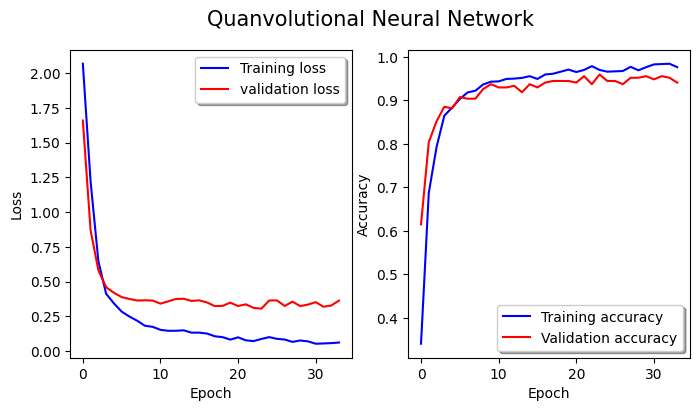

In [93]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.suptitle('Quanvolutional Neural Network',fontsize=15)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

In [94]:
np.mean(history.history['categorical_accuracy'][-10:]),np.mean(history.history['val_categorical_accuracy'][-10:])

(0.9747812211513519, 0.9481481432914733)

In [95]:
np.mean(history.history['loss'][-10:]),np.mean(history.history['val_loss'][-10:])

(0.07042229771614075, 0.3425111621618271)

In [96]:
yh = q_model.evaluate(q_test_images,to_categorical(y_test))
yhat = q_model.predict(q_test_images[:10])
np.argmax(yhat,axis=-1),y_test[:10]


1/1 [==============================] - 0s 84ms/step


(array([3, 8, 3, 5, 6, 6, 9, 6, 0, 7]), array([3, 8, 5, 5, 6, 6, 9, 6, 0, 7]))

In [119]:
def cnn_model():
  layer1 = layers.Conv2D(4,kernel_size=2,activation='relu',padding='same',input_shape=([8,8,1]))
  layer2 = layers.MaxPool2D((2,2))

  layer3 = layers.Conv2D(4,kernel_size=1,activation='relu',padding='same',trainable=False)
  layer4 = layers.MaxPool2D((2,2))

  # layer5 = layers.Conv2D(128,kernel_size=2,activation='relu',padding='same')
  # layer6 = layers.Conv2D(128,kernel_size=2,activation='relu',padding='same')
  # layer7 = layers.MaxPool2D((2,2))

  layer8 = layers.Flatten()
  layer12 = layers.Dense(32,activation='elu')
  layer9 = layers.Dense(16,activation='elu')
  drop1 = layers.Dropout(0.2)
  drop2 = layers.Dropout(0.2)
  layer11 = layers.Dense(10,activation = 'softmax')
  # ,layer5,layer6,layer7,layer4
  model = keras.Sequential([layer1,layer2,layer3,layer8,layer12,drop1,layer9,layer11])
  # model = keras.Sequential([layer1,layer2,layer3])
  return model

In [120]:
c_model = cnn_model()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
c_model.compile(optimizer = opt, loss='categorical_crossentropy',
             metrics=["categorical_accuracy"])

In [121]:
history_c = c_model.fit(x=x_train,y=to_categorical(y_train), validation_data = (x_val,to_categorical(y_val)),epochs=100,batch_size=100,verbose=1,callbacks=[callback])

Epoch 1/100
13/13 [==============================] - 2s 32ms/step - loss: 2.2154 - categorical_accuracy: 0.2092 - val_loss: 1.9944 - val_categorical_accuracy: 0.3963
Epoch 2/100
13/13 [==============================] - 0s 10ms/step - loss: 1.6753 - categorical_accuracy: 0.5211 - val_loss: 1.1870 - val_categorical_accuracy: 0.7259
Epoch 3/100
13/13 [==============================] - 0s 12ms/step - loss: 0.9805 - categorical_accuracy: 0.7367 - val_loss: 0.7792 - val_categorical_accuracy: 0.7704
Epoch 4/100
13/13 [==============================] - 0s 10ms/step - loss: 0.6498 - categorical_accuracy: 0.7820 - val_loss: 0.6518 - val_categorical_accuracy: 0.8037
Epoch 5/100
13/13 [==============================] - 0s 9ms/step - loss: 0.5068 - categorical_accuracy: 0.8178 - val_loss: 0.6352 - val_categorical_accuracy: 0.8037
Epoch 6/100
13/13 [==============================] - 0s 10ms/step - loss: 0.4761 - categorical_accuracy: 0.8401 - val_loss: 0.5615 - val_categorical_accuracy: 0.8259
Epoch

In [122]:
c_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 8, 8, 4)           20        
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 4, 4, 4)           0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 4, 4, 4)           20        
                                                                 
 flatten_15 (Flatten)        (None, 64)                0         
                                                                 
 dense_30 (Dense)            (None, 32)                2080      
                                                                 
 dropout_30 (Dropout)        (None, 32)                0         
                                                     

Text(0.5, 0.98, 'Convolutional Neural Network')

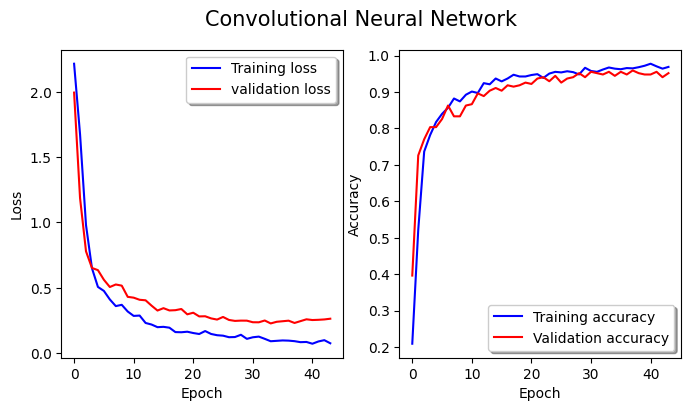

In [123]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(history_c.history['loss'], color='b', label="Training loss")
ax[0].plot(history_c.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)


ax[1].plot(history_c.history['categorical_accuracy'], color='b', label="Training accuracy")
ax[1].plot(history_c.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.suptitle('Convolutional Neural Network',fontsize=15)

In [124]:
yh_c = c_model.evaluate(x_test,to_categorical(y_test))
yhat_c = c_model.predict(x_test[:10])
np.argmax(yhat_c,axis=-1),y_test[:10]

1/1 [==============================] - 0s 71ms/step


(array([3, 8, 5, 5, 6, 6, 9, 6, 0, 7]), array([3, 8, 5, 5, 6, 6, 9, 6, 0, 7]))

In [125]:
np.mean(history_c.history['categorical_accuracy'][-10:]),np.mean(history_c.history['val_categorical_accuracy'][-10:])

(0.9679395496845246, 0.9503703653812409)

In [126]:
np.mean(history_c.history['loss'][-10:]),np.mean(history_c.history['val_loss'][-10:])

(0.08823054879903794, 0.24956498593091964)

### **Fashion Mnist**

In [ ]:
def load_fmnist(n_train,n_val):
    """Return training and testing data of digits dataset."""
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()
    # dat = sample(digits,n)

    x_train = x_train[:n_train]
    y_train = y_train[:n_train]
    x_val = x_val[:n_val]
    y_val = y_val[:n_val]


    x_train = x_train / 255
    x_val = x_val / 255

    x_vali,x_test,y_vali,y_test = train_test_split(x_val,y_val,test_size=0.5,random_state=2)
    # scaler = MinMaxScaler(feature_range = (0, 1))
    # x_train = scaler.fit_transform(x_train)
    # x_val = scaler.fit_transform(x_val)
    # Add extra dimension for convolution channels
    x_train = pnp.array(x_train[..., tf.newaxis], requires_grad=False)
    x_vali = pnp.array(x_vali[..., tf.newaxis], requires_grad=False)
    x_test = pnp.array(x_test[..., tf.newaxis], requires_grad=False)
    return (x_train,x_vali,y_train,y_vali,x_test,y_test)

In [ ]:
def load_fmnist_cnn(n_train,n_val):
    """Return training and testing data of digits dataset."""
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()
    # dat = sample(digits,n)

    x_train = x_train[:n_train]
    y_train = y_train[:n_train]
    x_val = x_val[:n_val]
    y_val = y_val[:n_val]


    x_train = x_train / 255
    x_val = x_val / 255

    x_vali,x_test,y_vali,y_test = train_test_split(x_val,y_val,test_size=0.5,random_state=2)
    x_train = x_train.reshape(len(x_train), 28, 28,1)
    x_vali = x_vali.reshape(len(x_vali), 28, 28,1)
    x_test = x_test.reshape(len(x_test), 28, 28,1)
    # scaler = MinMaxScaler(feature_range = (0, 1))
    # x_train = scaler.fit_transform(x_train)
    # x_val = scaler.fit_transform(x_val)
    # Add extra dimension for convolution channels
    # x_train = pnp.array(x_train[..., tf.newaxis], requires_grad=False)
    # x_vali = pnp.array(x_vali[..., tf.newaxis], requires_grad=False)
    # x_test = pnp.array(x_test[..., tf.newaxis], requires_grad=False)
    return (x_train,x_vali,y_train,y_vali,x_test,y_test)

In [ ]:
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(x_train[i], cmap='gray')
    ax[i].set_title(labeldict[y_train[i]])